# Assignment 3: MNIST with logistic regression

Module imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression

Function for reading data from .mat file

In [2]:
file_name = 'ex3data1.mat'
# we should use scipy.io for laoding the .mat file
def read_file(file_name):
    data = sio.loadmat(file_name)
    X = data['X']
    m = X.shape[0]
    y = data['y']
    # 0 is indexed 10 in the files (because of octave and matlab indexing system), returning it to 0...
    y = list(y.ravel())
    for i in range(len(y)):
        if y[i] == 10:
            y[i] = 0
            
    # matrix data is rotated CCW so we rotate it 90 degrees CW
    for i in range(m):
        number = X[i].reshape(20, 20)
        number = np.rot90(number)
        X[i] = number.ravel()
    
    y = np.array(y).reshape(m, 1)
    return X, y

In [3]:
X, y = read_file(file_name)

Plotting 10 numbers

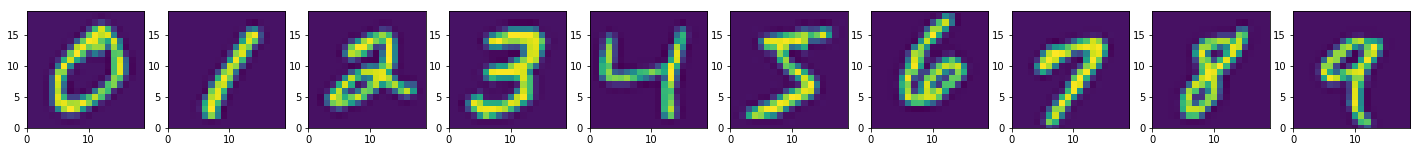

In [4]:
fig = plt.figure()
fig.set_figheight(50)
fig.set_figwidth(50)
for i in range(0, 5000, 500):
    fig.add_subplot(1, 20, 1+i/500)
    plt.xlim(0, 19)
    plt.ylim(0, 19)
    number = X[i].reshape(20, 20)
    plt.imshow(number)
plt.show()

Assign m and n

In [5]:
m = X.shape[0] # 5000, no. of training data
n = X.shape[1] # 400, no. of features

Typical functions for logistic regression

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def h(X, theta):
    # X is a matrix and theta is a vector, we need a vector as our answer
    return sigmoid(np.matmul(X, theta))

def single_h(x, theta):
    # x and theta are both vectors. this function is used to simplify measuring accuracy
    return np.matmul(theta.T, x)

Cost and gradient function, and gradient descent

In [7]:
def cost(X, y, theta):
    m = X.shape[0]
    # cost = (-1/m) * (yT*log(h) + (1-y)T*log(1-h))
    first = np.matmul(y.T, np.log(h(X, theta)))
    second = np.matmul((1 - y).T, np.log(1 - h(X, theta)))
    return (-1 / m) * (first + second)

def gradient(X, y, theta):
    m = X.shape[0]
    # gradient = (1/m) *  (XT*(h-y))
    ans = np.matmul(X.T, h(X, theta) - y)
    return (1 / m) * ans

def gradient_descent(X, y, theta, iters=4000, alpha=0.01):
    for i in range(iters):
        theta = theta - alpha * gradient(X, y, theta)
    return theta

Since we are using "One vs. All" method, we're gonna need to change y to a binary vector 

In [8]:
def refine_y(y, num):
    m = y.shape[0]
    y = list(y.ravel())
    
    for i in range(len(y)):
        if y[i] == num:
            y[i] = 1
        else:
            y[i] = 0
    
    return np.array(y).reshape(m, 1)

## Method 1: Gradient descent

In [9]:
# we should append a x0=1 column to our X matrix
x0s = np.ones((m, 1))
gd_X = np.append(x0s, X, axis=1)

gd_thetas = []
for i in range(0, 10):
    # we are building the classifier for each digit i in each loop
    
    # theta is a 401x1 vector (400+1), because of x0s
    theta = np.zeros((n+1, 1))
    
    # refine y to suit our current digit
    new_y = refine_y(y, i)
    
    theta = gradient_descent(gd_X, new_y, theta)
    gd_thetas.append(theta)

### Measuring accuracy of method 1

In [10]:
# comparing the prediction of our method with the real value (y)
total = m
corrects = 0

# loop through all training data:
for i in range(m):
    
    # it's ((n+1, 1)) because of x0 = 1 in gd_X
    x = gd_X[i].ravel().reshape((n+1, 1))
    
    # now, for each training data, calculate the results of each classifier (we have 10 classifiers)
    probabilities = []
    for theta in gd_thetas:
        prob = single_h(x, theta)
        probabilities.append(prob)
    

    prediction_prob = max(probabilities)
    
    number_predicted = probabilities.index(prediction_prob)
    
    if number_predicted == y[i][0]:
        corrects += 1

print('Gradient descent accuracy: %{0}'.format(100 * corrects / m))

Gradient descent accuracy: %88.1


## Method 2: Scikit learn

In [11]:
regressors = []
for i in range(0, 10):
    regressor = LogisticRegression()
    
    # refine y to suit our current digit
    new_y = refine_y(y, i)
    
    # sklearn accepts a 1d array as y so we ravel() the vector
    regressor.fit(X, new_y.ravel())
    regressors.append(regressor)

### Measuring accuracy of method 2

In [12]:
# comparing the prediction of our method with the real value (y)
total = m
corrects = 0

# loop through all training data:
for i in range(m):
    # sklearn accepts 2d array as input to predict
    x = [X[i]]
    
    # now, for each training data, calculate the results of each classifier (we have 10 classifiers)
    predictions = []
    for regressor in regressors:
        prediction = regressor.predict(x)
        predictions.append(prediction)
    
    try:
        number_predicted = predictions.index(1)
    except: 
        number_predicted = -1
    
    if number_predicted == y[i][0] and predictions.count(1) == 1:
        corrects += 1

print('Scikit learn accuracy: %{0}'.format(100 * corrects / m))

Scikit learn accuracy: %86.7
